In [ ]:
import numpy as np
import matplotlib.pyplot as plt

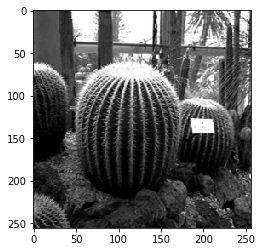

In [ ]:
#Reading the inputs
im_l = plt.imread("hw1-left-gray.png")
im_r = plt.imread("hw1-right-gray.png")

im_l = im_l[:,:,0]
im_r = im_r[:,:,0]

In [ ]:
#Utility functions to generate the responsibility functions
def psif1(ds, sigma, i, j, im_l, im_r):
    h,w = im_l.shape
    if j+ds < w:
        a = (-1/2)*((im_l[i, j] - im_r[i, j+ds])**2)*(1/sigma**2)
    else:
        a = (-1/2)*((im_l[i, j] - im_r[i, w-1])**2)*(1/sigma**2)
    return np.exp(a)

def psif2(ds, dt, gamma,delta):
    a = min((ds-dt)**2,delta**2)
    return np.exp(a*(-1/2)*(1/gamma*2))

#Function to generate arrays with values of psif1 and psif2 for each pixel (node)
def generate_psi(im_l,im_r,d_max,sigma,gamma,delta):
    h,w = im_l.shape
    sigma = 0.05
    gamma = 10
    d_max = 10

    psi1 = np.zeros((h,w,10))
    for i in range(h):
        for j in range(w):
            for d in range(10):
                psi1[i,j,d] = psif1(d+1,sigma,i,j,im_l,im_r)

    psi2 = np.zeros((10,10))
    for i in range(10):
        for j in range(10):
            psi2[i,j] = psif2(i,j,gamma,delta)
    
    return psi1,psi2

In [ ]:
#Function to implement Sum-Product algorithm to determine the disparity estimates
#Input : Left stereo Image (im_l) and right stereo image (im_r)
#Output : A numpy array of the same dimensions as the stereo images giving the converged disparity values of each pixel
#Note: The disparity values are assumed to be quantised to 10 levels

#Functions:
#disparity_estimate : main function
#propagate : Takes a message matrix as input and propagates the message across rows, outputs the resulting message matrix
#normalise : To normalise the message matrix after each iteration to prevent overflow
#infer : Calculates the disparity estimates from the message matrix

def propagate(M,psi1,psi2):
    h = M.shape[0]
    w = M.shape[1]
    for i in range(h):
        for j in range(w):
            prod = np.ones((d_max))
            k = 0
            for ii in [-1,0,1]:
                for jj in [-1,0,1]:
                    if i + ii > -1 and i + ii < h and j + jj > -1 and j + jj < w and (ii != 0 and jj != 0):
                        prod = prod*M[i,j,k]
                    if (ii != 0 and jj != 0):
                        k += 1

            k = 0
            for ii in [-1,0,1]:
                for jj in [-1,0,1]:
                    if i + ii > -1 and i + ii < h and j + jj > -1 and j + jj < w and (ii != 0 and jj != 0):
                        for d_s in range(d_max):
                            summ = 0
                            for d_t in range(d_max):
                                summ += psi1[i,j,d_t] * psi2[d_s,d_t] * (prod[d_t]/M[i+ii,j+jj,7-k,d_t])
                            M[i,j,k,d_s] = summ
                    if (ii != 0 and jj != 0):
                        k += 1
    return M

def normalise(M):
    n_factor = (np.mean(M)) ** 2
    M = M/n_factor
    return M
    
def infer(M,psi1):
    h = M.shape[0]
    w = M.shape[1]
    prob_mat = np.zeros((h,w,d_max))
    for i in range(h):
        for j in range(w):
            for d in range(d_max):
                prod = 1
                for ii in [-1,0,1]:
                    for jj in [-1,0,1]:
                        if i + ii > -1 and i + ii < h and j + jj > -1 and j + jj < w and (ii != 0 and jj != 0):
                            prod = prod * M[i+ii,j+jj,7-k,d]
                prob_mat[i,j,d] = psi1[i,j,d]*prod
                
    dispar = np.argmax(prob_mat, axis = 2)
    return dispar

def disparity_estimate(im_l,im_r):
    h,w = im_l.shape

    #Hyperparameters:
    sigma = 0.05
    gamma = 10
    d_max = 10
    delta = 50
    
    psi1,psi2 = generate_psi(im_l,im_r,d_max,sigma,gamma,delta)
    
    #M is a 3d array of size (h,w,8,d_max) containing the messages by each pixel to it's neighbours
    M = np.ones((h,w,8,d_max))
    
    itr = 3 #Number of iterations
    for iteration in range(itr):
        print("Iteration",iteration + 1)
        M = propagate(M,psi1,psi2)
        M = normalise(M)
    
    disparity = infer(M,psi1)
    return disparity

Iteration 1
Iteration 2
Iteration 3


Text(0.5, 1.0, 'Disparity map')

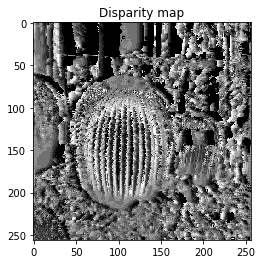

In [ ]:
ans = disparity_estimate(im_l,im_r)
plt.imshow(ans, cmap = 'gray')
plt.title("Disparity map")

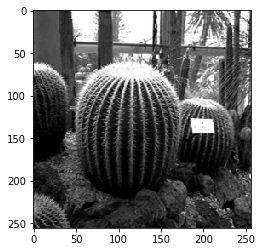

In [ ]:
plt.imshow(im_l,cmap='gray')
plt.title("Original Image")